# Th analysis, November 2017

In [1]:
%matplotlib inline

import os
import random 
import sys
import textwrap

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   matplotlib.font_manager                 import FontProperties
from   mpl_toolkits.mplot3d                    import Axes3D

## Function definitions

In [2]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)

# code from Gonzalo
def reso(values,epeak):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (epeak/2458)**0.5

def reso_errors(values,errors,epeak):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return err_r, err_r * (epeak/2458)**0.5

def gausstext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values,epeak)))

def gaussexpotext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3],epeak)))

-------------------------

# Save/load main event quantities

In [3]:
# overall energy calibration factor
CAL_FACTOR = 1.055   # 7bar runs, new correction tables
#CAL_FACTOR = 1592/394000
#CAL_FACTOR = 1592/465600   # 7bar runs
#CAL_FACTOR = 1616/328400   # MC

# number of active PMTs
npmts = 11

#evtfnames = ["data/param_sweep/npz_combined_4735_rebin2_qlm45.npz"]
evtfnames = ["data/npz_combined_4735.npz", "data/npz_combined_4737.npz", "data/npz_combined_4739.npz"]
#evtfnames = ["data/npz_combined_MC4595.npz"]
#evtfnames = ["228th_arrays_r4717.npz", "228th_arrays_r4718_f0_3000.npz", "228th_arrays_r4718_f3000_6054.npz", 
#             "228th_arrays_r4719.npz", "228th_arrays_r4720.npz"]

## Load the information directly from files

In [4]:
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_ntrks = []; A_lmtrk = []; A_nvox = []
A_Ec = []; A_Ec_avg = []; A_Ec_tau = []; A_Ec_geo = []; A_Ec_gtglobal = []; A_E0 = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
A_xmin = []; A_ymin = []; A_zmin = []
A_xmax = []; A_ymax = []; A_zmax = []
A_rmin = []; A_rmax = []
for fname in evtfnames:

    fn = np.load(fname)
    A_eblob1 = np.concatenate((A_eblob1,fn['A_eblob1']))
    A_eblob2 = np.concatenate((A_eblob2,fn['A_eblob2']))
    A_emtrk  = np.concatenate((A_emtrk,fn['A_emtrk']))
    A_ntrks  = np.concatenate((A_ntrks,fn['A_ntrks']))
    A_lmtrk  = np.concatenate((A_lmtrk,fn['A_lmtrk']))
    A_nvox   = np.concatenate((A_nvox,fn['A_nvox']))
    A_Ec     = np.concatenate((A_Ec,fn['A_Ec']))
    A_Ec_avg = np.concatenate((A_Ec_avg,fn['A_Ec_avg']))
    A_Ec_tau = np.concatenate((A_Ec_tau,fn['A_Ec_tau']))
    A_Ec_geo = np.concatenate((A_Ec_geo,fn['A_Ec_geo']))
    A_Ec_gtglobal = np.concatenate((A_Ec_gtglobal,fn['A_Ec_gtglobal']))
    A_E0     = np.concatenate((A_E0,fn['A_E0']))
    A_xavg   = np.concatenate((A_xavg,fn['A_xavg']))
    A_yavg   = np.concatenate((A_yavg,fn['A_yavg']))
    A_zavg   = np.concatenate((A_zavg,fn['A_zavg']))
    A_ravg   = np.concatenate((A_ravg,fn['A_ravg']))
    A_xmin   = np.concatenate((A_xmin,fn['A_xmin']))
    A_ymin   = np.concatenate((A_ymin,fn['A_ymin']))
    A_zmin   = np.concatenate((A_zmin,fn['A_zmin']))
    A_xmax   = np.concatenate((A_xmax,fn['A_xmax']))
    A_ymax   = np.concatenate((A_ymax,fn['A_ymax']))
    A_zmax   = np.concatenate((A_zmax,fn['A_zmax']))
    A_rmin   = np.concatenate((A_rmin,fn['A_rmin']))
    A_rmax   = np.concatenate((A_rmax,fn['A_rmax']))

--------------------------

# Distributions and analysis of all events
At this point we have arrays containing key information from each event.  Here we construct plots from those arrays.<br>

`A_eblob1`  -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`  -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`   -- energy of most energetic Paolina track in event<br>
`A_lmtrk`   -- length of most energetic Paolina track in event<br>
`A_ntrks`   -- number of tracks in the event<br>
`A_nvox`    -- number of voxels in the event<br>
`A_Ec`      -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Ec_avg`  -- corrected energy (lifetime by average $z$, $(x,y)$ by average $x$ and $y$)<br>
`A_Ec_tau`  -- corrected energy (lifetime only, by hit)<br>
`A_Ec_geo`  -- corrected energy (geometry only, by hit)<br>
`A_E0`      -- uncorrected energy<br>
`A_xavg`    -- average reconstructed $x$-coordinate of event<br>
`A_yavg`    -- average reconstructed $y$-coordinate of event<br>
`A_zavg`    -- average reconstructed $z$-coordinate of event<br>
`A_ravg`    -- average $r = \sqrt{x^2 + y^2}$ of event<br>
`A_xmin`    -- minimum reconstructed $x$-coordinate of event<br>
`A_ymin`    -- minimum reconstructed $y$-coordinate of event<br>
`A_zmin`    -- minimum reconstructed $z$-coordinate of event<br>
`A_xmax`    -- maximum reconstructed $x$-coordinate of event<br>
`A_ymax`    -- maximum reconstructed $y$-coordinate of event<br>
`A_zmax`    -- maximum reconstructed $z$-coordinate of event<br>

In [5]:
# Key variables in constructing cuts.
Emin = 0; Emax = 800000                  # basic cut energy range
eb1_low = 1100; eb1_high = 1275          # blob plot intervals
eb2_low = 1590; eb2_high = 1645
eb3_low = 1800; eb3_high = 2500
Emin_emtrk = 1000; Emax_emtrk = 2500     # emtrk basic energy cut range

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
#C_basic       = (A_E0 > Emin) & (A_E0 < Emax) & (A_Ec > Emin) & (A_Ec < Emax) & (A_Ec_tau > Emin) & (A_Ec_tau < Emax) & (A_Ec_avg > Emin) & (A_Ec_avg < Emax) & (A_zavg < 580)
#C_tfiducial   = (abs(A_xmax) < 100) & (abs(A_ymax) < 100) & (abs(A_xmin) < 100) & (abs(A_ymin) < 100) & (A_zavg > 50) & (A_zavg < 150)
C_basic       = (A_E0 > 0) & (A_Ec > 0) & (A_Ec_tau > 0) & (A_Ec_avg > 0) & (A_zavg < 580)
C_wide        = C_basic & (A_zmin > 50) & (A_zmax < 500) & (A_rmax < 200)
C_tight       = C_wide  & (A_zmin > 150) & (A_zmax < 300) & (A_rmax < 160)
C_blobs       = (A_eblob2*CAL_FACTOR < 200)
C_tightwblobs = C_tight & C_blobs
C_widewblobs  = C_wide & C_blobs

# Cuts defining different spectral regions
C_trks                 = (A_lmtrk > 90) & (A_lmtrk < 180) & (A_ntrks == 1)
C_basic_emtrk          = C_trks & (A_emtrk*CAL_FACTOR > Emin_emtrk) & (A_emtrk*CAL_FACTOR < Emax_emtrk)
C_Ec_regionprepeak     = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb1_low) & (A_Ec*CAL_FACTOR < eb1_high)
C_Ec_regionpeak        = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb2_low) & (A_Ec*CAL_FACTOR < eb2_high)
C_Ec_regionpostpeak    = C_basic_emtrk & (A_Ec*CAL_FACTOR > eb3_low) & (A_Ec*CAL_FACTOR < eb3_high)
C_emtrk_regionprepeak  = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb1_low) & (A_emtrk*CAL_FACTOR < eb1_high)
C_emtrk_regionpeak     = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb2_low) & (A_emtrk*CAL_FACTOR < eb2_high)
C_emtrk_regionpostpeak = C_basic_emtrk & (A_emtrk*CAL_FACTOR > eb3_low) & (A_emtrk*CAL_FACTOR < eb3_high)

print("Events in key quantities: {0}".format(len(A_eblob1)))

Events in key quantities: 815892


## Energy spectra using different corrections

[ 688.00404519  370.68942124  349.70229409 ...,  435.03813952  497.07893882
  633.87549987]


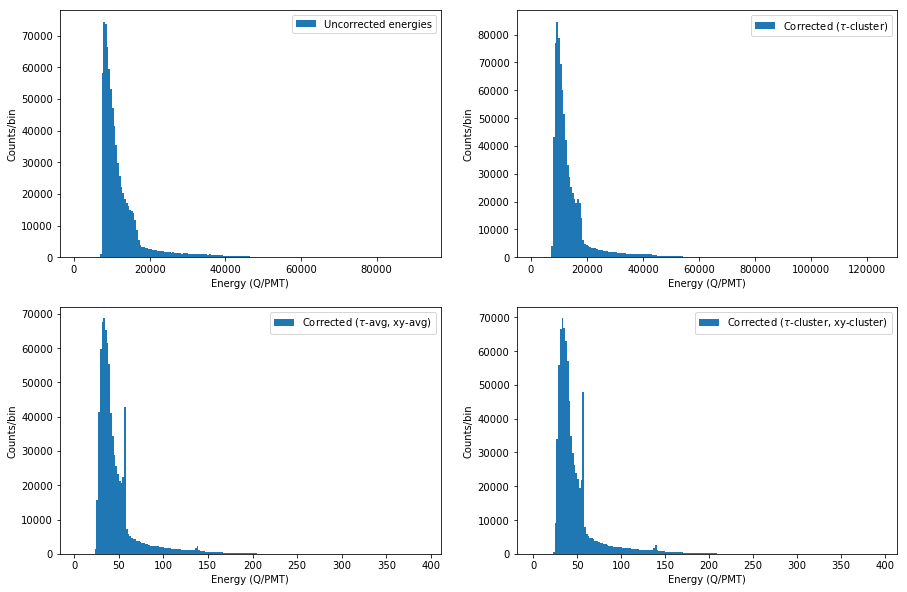

In [6]:
cuts_espectra = C_basic
print(A_Ec_avg)
ebins = 200

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_E0[cuts_espectra]/npmts,bins=ebins,label='Uncorrected energies')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_Ec_tau[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(A_Ec_avg[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-avg, xy-avg)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(A_Ec[cuts_espectra]/npmts,bins=ebins,label='Corrected ($\\tau$-cluster, xy-cluster)')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

## Paolina tracks and voxel distributions

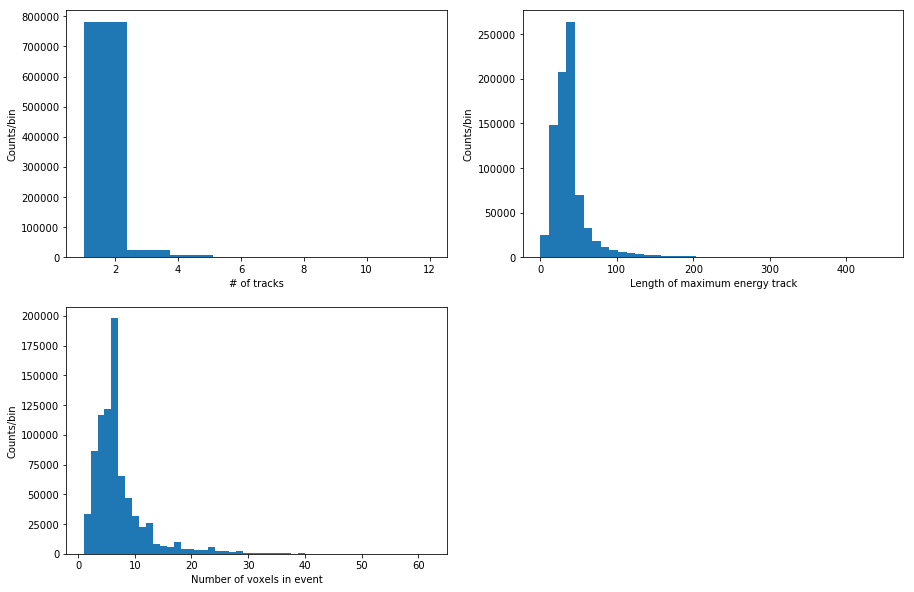

In [7]:
cuts_trkplots = C_basic
ntrk_bins = 8
lmtrk_bins = 40
nvox_bins = 50

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(A_ntrks[cuts_trkplots],bins=ntrk_bins)
plt.xlabel('# of tracks')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(A_lmtrk[cuts_trkplots],bins=lmtrk_bins)
plt.xlabel('Length of maximum energy track')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(223)
plt.hist(A_nvox[cuts_trkplots],bins=nvox_bins)
plt.xlabel('Number of voxels in event')
plt.ylabel('Counts/bin')

## Blob energy plots

Number of events I1 (1100.00 keV, 1275.00 keV): 3216
Number of events I2 (1590.00 keV, 1645.00 keV): 1630
Number of events I3 (1800.00 keV, 2500.00 keV): 886
Some long events in peak region above 300 keV (2-blobs):
[]
Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):
[]


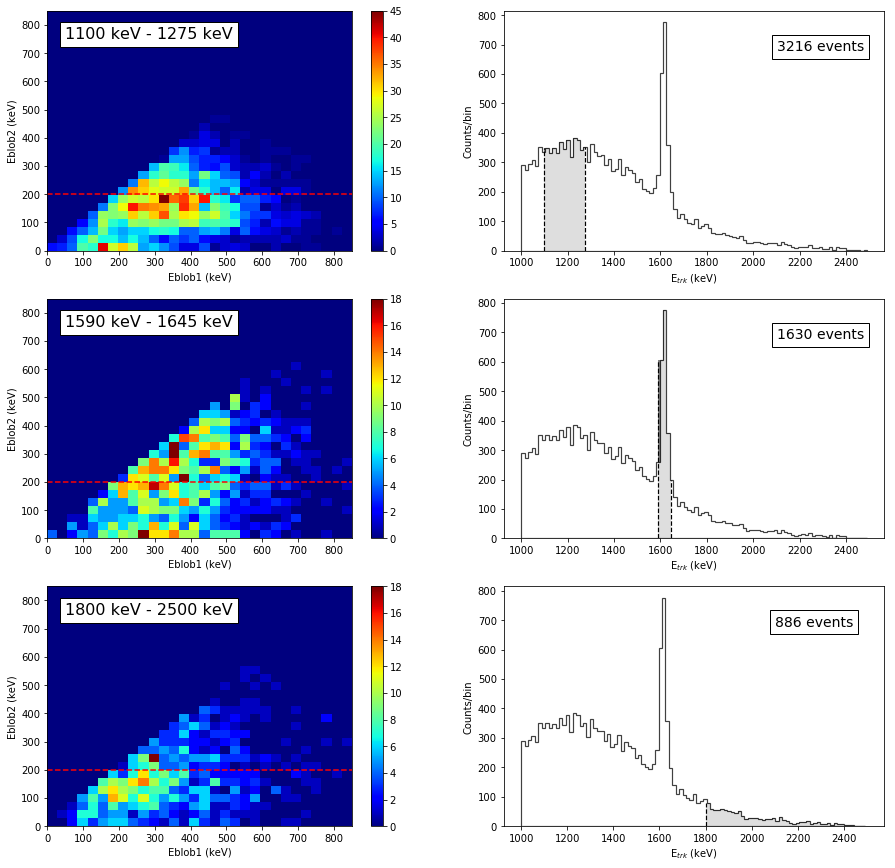

In [8]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 30

fig = plt.figure(3)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

# histogram range
hrange = 850

# label locations
label_blobhist_x = 50
label_blobhist_y = 750
label_evthist_x = 2100

# horizontal reference line
hline_y = 200

# cuts
cuts_1 = C_emtrk_regionprepeak & C_wide
cuts_2 = C_emtrk_regionpeak & C_wide
cuts_3 = C_emtrk_regionpostpeak & C_wide

print("Number of events I1 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb1_low,eb1_high,len(A_eblob1[cuts_1])))
print("Number of events I2 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb2_low,eb2_high,len(A_eblob1[cuts_2])))
print("Number of events I3 ({0:.2f} keV, {1:.2f} keV): {2}".format(eb3_low,eb3_high,len(A_eblob1[cuts_3])))

pltevts_2e = cuts_2 & (A_eblob2*CAL_FACTOR > 300) & (A_lmtrk > 180)
pltevts_1e = cuts_2 & (A_eblob2*CAL_FACTOR >= 40) & (A_eblob2*CAL_FACTOR <= 200) & (A_lmtrk > 180)
print("Some long events in peak region above 300 keV (2-blobs):")
print([i for i,x in enumerate(pltevts_2e) if x][0:20])
print("Some long events in peak region 40 <= Eblob <= 200 keV (1-blob):")
print([i for i,x in enumerate(pltevts_1e) if x][0:20])

# -----------------------------------------------
# interval 1
ax1 = fig.add_subplot(321)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_1]*CAL_FACTOR, A_eblob1[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange],[0,hrange]])
ax1.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low,eb1_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

ax2 = fig.add_subplot(322)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb1_low
high_cut = eb1_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax2.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_1])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax2.set_xlabel('E$_{trk}$ (keV)')
ax2.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 2
ax3 = fig.add_subplot(323)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_2]*CAL_FACTOR, A_eblob1[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange],[0,hrange]])
ax3.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low,eb2_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

ax4 = fig.add_subplot(324)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb2_low
high_cut = eb2_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax4.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_2])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax4.set_xlabel('E$_{trk}$ (keV)')
ax4.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 3
ax5 = fig.add_subplot(325)
hxy, xxy, yxy = np.histogram2d(A_eblob2[cuts_3]*CAL_FACTOR, A_eblob1[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange],[0,hrange]])
ax5.text(label_blobhist_x, label_blobhist_y, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low,eb3_high), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent5 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp5 = ax5.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax5.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax5.set_xlabel("Eblob1 (keV)")
ax5.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp5)

ax6 = fig.add_subplot(326)
n, bins, patches = plt.hist(A_emtrk[C_basic_emtrk]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = eb3_low
high_cut = eb3_high
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax6.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_3])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax6.set_xlabel('E$_{trk}$ (keV)')
ax6.set_ylabel('Counts/bin')

plt.savefig("fig/CSTL_blobs_3regions.pdf", bbox_inches='tight')

----------------

## Background-subtracted blob energy distributions

In [9]:
# define standard cuts for events to be used in this analysis
bgss_rng = [1300,2000]
cuts_bgss = C_wide & C_trks & (A_emtrk*CAL_FACTOR > bgss_rng[0]) & (A_emtrk*CAL_FACTOR < bgss_rng[1])

### First, obtain the fit parameters for the double-escape peak

[ 5283.15438028  1613.87544252    11.20810499    62.54615385   343.16691125
  1442.28900399]
4.5 keV/bin


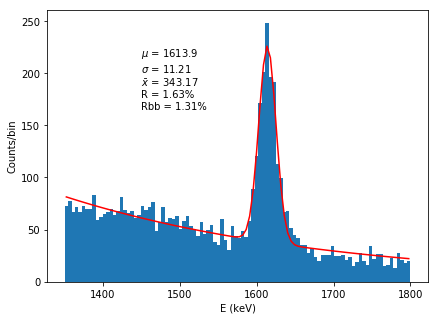

In [10]:
# Track energy spectrum, focusing on double-escape peak
plt_rng = [1350,1800]
nbins = 100
fit_rng_low = 1350
fit_rng_high = 1800
text_x = 1450
fit_gauss_A = 120
fit_gauss_mu = 1610
fit_gauss_sigma = 30
fit_exp_A = 20
fit_exp_mean = 600
fit_exp_x0 = 1200

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(A_emtrk[cuts_bgss]*CAL_FACTOR, nbins, range=plt_rng)

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4*max(y)/6, gaussexpotext(f.values,1592.))
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
#plt.title("")

# Save the parameters for later use.
# -- gaussian fit for signal:        As/(sqrt(2pi)*sg)*exp(-(E-mu)**2/(2sg**2))
# -- exponential fit for background: Ab*exp(-(E-E0)/L)
param_As = f.values[0]
param_mu = f.values[1]
param_sg = f.values[2]
param_Ab = f.values[3]
param_L  = f.values[4]
param_E0 = f.values[5]
bin_size = (plt_rng[1]-plt_rng[0])/nbins
print(f.values)
print("{0} keV/bin".format(bin_size))

### Now make the background subtracted distribution

In [11]:
# ---------------------------------------------------
# Define the regions

# The signal region will be mu +/- Nsigma*sigma.
Nsigma = 2

# The background region will be [mu-(Nsigma+Nspace+Nbsigma)*sigma,mu-(Nsigma+Nspace)*sigma] 
#                           and [mu+(Nsigma+Nspace)*sigma,mu+(Nsigma+Nspace+Nbsigma)*sigma]
Nbsigma = 7
Nspace = 6

Es1 = param_mu - param_sg*Nsigma
Es2 = param_mu + param_sg*Nsigma

Eb1a = param_mu - param_sg*(Nsigma+Nspace+Nbsigma)
Eb2a = param_mu - param_sg*(Nsigma+Nspace)
Eb1b = param_mu + param_sg*(Nsigma+Nspace)
Eb2b = param_mu + param_sg*(Nsigma+Nspace+Nbsigma)
# ---------------------------------------------------
# Compute the number of signal and background events in the peak
nb_theory = 2*param_L*param_Ab*math.exp((param_E0-param_mu)/param_L)*math.sinh(Nsigma*param_sg/param_L)/bin_size
ns_theory = param_As*math.erf(Nsigma/math.sqrt(2))/bin_size
ntot = len(A_emtrk[cuts_bgss & (A_emtrk*CAL_FACTOR > Es1) & (A_emtrk*CAL_FACTOR < Es2)])

print("Range ({0},{1})".format(Es1,Es2))
print("Theory: background = {}, signal = {}, total = {}".format(nb_theory,ns_theory,nb_theory+ns_theory))
print("Actual total = {}".format(ntot))

# Compute the theoretical fraction of background events in the signal region.
f_bg = nb_theory/(nb_theory+ns_theory)
print("\n** Theoretical background fraction = {}".format(f_bg))

Range (1591.459232543803,1636.2916525047367)
Theory: background = 378.21440544459915, signal = 1120.6154359485881, total = 1498.8298413931873
Actual total = 1506

** Theoretical background fraction = 0.25233978868010964


Number of events in signal region (1591.46 keV, 1636.29 keV): 1506
Number of events in background region (1445.75 keV, 1524.21 keV) and (1703.54 keV, 1782.00 keV): 1446
Sum of signal region histogram = 1505.0
Sum of background region histogram = 1442.0
Sum of subtracted histogram = 1.0 before min() operation


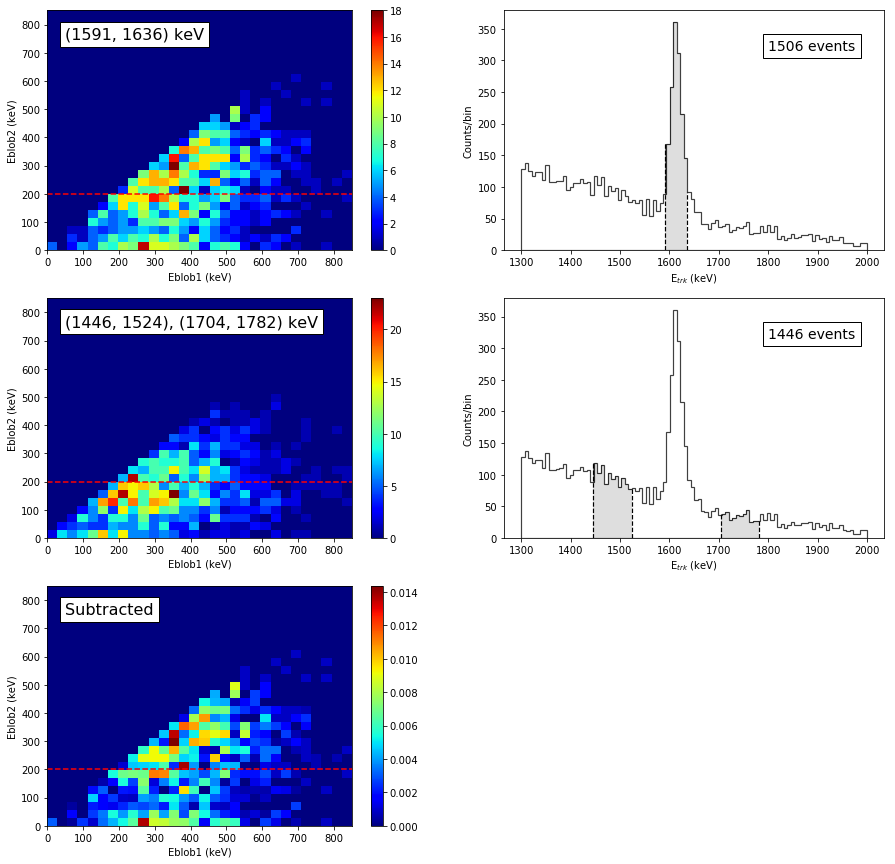

In [12]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 30

fig = plt.figure()
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

# histogram range
hrange = 850

# label locations
label_blobhist_x = 50
label_blobhist_y = 750
label_evthist_x = 1800

# horizontal reference line
hline_y = 200

# cuts for signal and background regions
cuts_sg = cuts_bgss & (A_emtrk*CAL_FACTOR > Es1) & (A_emtrk*CAL_FACTOR < Es2)
cuts_bg = cuts_bgss & (((A_emtrk*CAL_FACTOR > Eb1a) & (A_emtrk*CAL_FACTOR < Eb2a)) | ((A_emtrk*CAL_FACTOR > Eb1b) & (A_emtrk*CAL_FACTOR < Eb2b)))

print("Number of events in signal region ({0:.2f} keV, {1:.2f} keV): {2}".format(Es1,Es2,len(A_eblob1[cuts_sg])))
print("Number of events in background region ({0:.2f} keV, {1:.2f} keV) and ({2:.2f} keV, {3:.2f} keV): {4}".format(Eb1a,Eb2a,Eb1b,Eb2b,len(A_eblob1[cuts_bg])))

# -----------------------------------------------
# interval 1
ax1 = fig.add_subplot(321)
hsgxy, xsgxy, ysgxy = np.histogram2d(A_eblob2[cuts_sg]*CAL_FACTOR, A_eblob1[cuts_sg]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange],[0,hrange]])
ax1.text(label_blobhist_x, label_blobhist_y, '({0:.4g}, {1:.4g}) keV'.format(Es1,Es2), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [ysgxy[0], ysgxy[-1], xsgxy[0], xsgxy[-1]]
sp1 = ax1.imshow(hsgxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

ax2 = fig.add_subplot(322)
n, bins, patches = plt.hist(A_emtrk[cuts_bgss]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);
low_cut = Es1
high_cut = Es2
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)
ax2.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_sg])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax2.set_xlabel('E$_{trk}$ (keV)')
ax2.set_ylabel('Counts/bin')

# -----------------------------------------------
# interval 2
ax3 = fig.add_subplot(323)
hbgxy, xbgxy, ybgxy = np.histogram2d(A_eblob2[cuts_bg]*CAL_FACTOR, A_eblob1[cuts_bg]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange],[0,hrange]])
ax3.text(label_blobhist_x, label_blobhist_y, '({0:.4g}, {1:.4g}), ({2:.4g}, {3:.4g}) keV'.format(Eb1a,Eb2a,Eb1b,Eb2b), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [ybgxy[0], ybgxy[-1], xbgxy[0], xbgxy[-1]]
sp3 = ax3.imshow(hbgxy, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

ax4 = fig.add_subplot(324)
n, bins, patches = plt.hist(A_emtrk[cuts_bgss]*CAL_FACTOR,bins=100,histtype='stepfilled')
plt.setp(patches, 'facecolor', 'w', 'edgecolor', 'black', 'linewidth', 1.2, 'alpha', 0.75);

low_cut = Eb1a
high_cut = Eb2a
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)

low_cut = Eb1b
high_cut = Eb2b
fill_bins = []; fill_n = []
for bv,nv in zip(bins,n):
    if(bv > low_cut and bv < high_cut):
        if(len(fill_bins) == 0):
            fill_bins.append(low_cut)
        else:
            fill_bins.append(bv)
        fill_n.append(nv)
fill_bins.append(high_cut)
fill_bins_arr = np.asarray(fill_bins); fill_n_arr = np.asarray(fill_n)
plt.fill_between(fill_bins_arr.repeat(2)[1:-1],fill_n_arr.repeat(2),facecolor='gray')
plt.vlines(low_cut,0,fill_n[0],linestyle='dashed',color='black',linewidth=1.2)
plt.vlines(high_cut,0,fill_n[-1],linestyle='dashed',color='black',linewidth=1.2)

ax4.text(label_evthist_x, 7*max(n)/8, '{0} events'.format(len(A_eblob1[cuts_bg])), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=14)
ax4.set_xlabel('E$_{trk}$ (keV)')
ax4.set_ylabel('Counts/bin')

# ------------------------------------------------------------------------------------
# Subtract the two histograms
nevts_sg = sum(sum(hsgxy))
nevts_bg = sum(sum(hbgxy))
hsub = ((hsgxy/nevts_sg) - f_bg*(hbgxy/nevts_bg))/(1-f_bg)
nevts_sub = sum(sum(hsub))
hsub[hsub < 0] = 0.0  # set minimum value to 0
print("Sum of signal region histogram = {}".format(nevts_sg))
print("Sum of background region histogram = {}".format(nevts_bg))
print("Sum of subtracted histogram = {} before min() operation".format(nevts_sub))

ax5 = fig.add_subplot(325)
ax5.text(label_blobhist_x, label_blobhist_y, 'Subtracted', 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent5 = [ybgxy[0], ybgxy[-1], xbgxy[0], xbgxy[-1]]
sp5 = ax5.imshow(hsub, extent=extent5, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax5.axhline(y=hline_y,xmin=0,xmax=hrange*CAL_FACTOR,c="red",linewidth=1.5,linestyle='dashed')
ax5.set_xlabel("Eblob1 (keV)")
ax5.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp5)

plt.savefig("fig/CSTL_blobs.pdf", bbox_inches='tight')

------------

## Signal efficiency vs. background rejection

In [13]:
# define standard cuts for events to be used in this analysis
svsb_rng = [1300,2000]
cuts_svsb = C_wide & C_trks & (A_emtrk*CAL_FACTOR > svsb_rng[0]) & (A_emtrk*CAL_FACTOR < svsb_rng[1])


Blob cut = 0: Range (1591.459232543803,1636.2916525047367)
Theory: background = 379.1478695117872, signal = 1142.9616524898893, total = 1522.1095220016764
Actual total = 1506

Blob cut = 50: Range (1591.459232543803,1636.2916525047367)
Theory: background = 335.80981378849987, signal = 968.4841581469798, total = 1304.2939719354797
Actual total = 1278


/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))



Blob cut = 100: Range (1591.459232543803,1636.2916525047367)
Theory: background = 275.99259390368655, signal = 876.0365088062608, total = 1152.0291027099474
Actual total = 1139

Blob cut = 150: Range (1591.459232543803,1636.2916525047367)
Theory: background = 202.19690194762956, signal = 779.6184541504505, total = 981.81535609808
Actual total = 964

Blob cut = 200: Range (1591.459232543803,1636.2916525047367)
Theory: background = 129.992563349787, signal = 625.842773566865, total = 755.8353369166521
Actual total = 740

Blob cut = 250: Range (1591.459232543803,1636.2916525047367)
Theory: background = 74.42657127141321, signal = 502.18318546231313, total = 576.6097567337264
Actual total = 562

Blob cut = 300: Range (1591.459232543803,1636.2916525047367)
Theory: background = 40.96540899186029, signal = 353.23471530636465, total = 394.2001242982249
Actual total = 382

Blob cut = 350: Range (1591.459232543803,1636.2916525047367)
Theory: background = 17.062452040435375, signal = 191.9985526

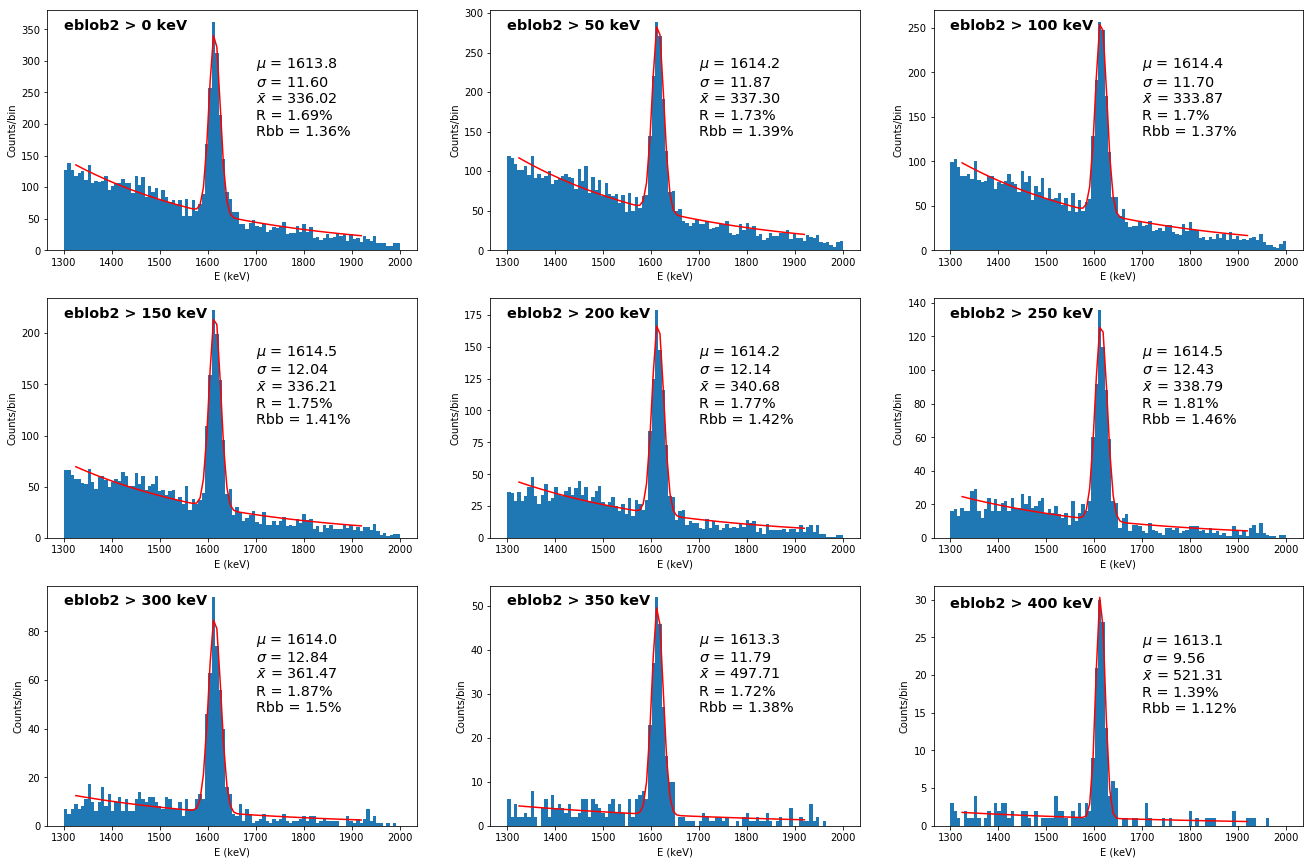

In [14]:
# Perform the fit for several values of the blob cut.
bcut_vals = np.arange(0,450,50)
plt_rng = svsb_rng

nbins = 100
fit_rng_low = 1320
fit_rng_high = 1920
text_x = 1700
text_bcut_x = 1300
fit_gauss_A = 200
fit_gauss_mu = 1620
fit_gauss_sigma = 15
fit_exp_A = 20
fit_exp_mean = 600
fit_exp_x0 = 1200

font0 = FontProperties()
font0.set_size('x-large')
font0.set_weight('bold')

font1 = FontProperties()
font1.set_size('x-large')

# The signal region will be mu +/- Nsigma*sigma.
Nsigma = 2
Es1 = param_mu - param_sg*Nsigma
Es2 = param_mu + param_sg*Nsigma

# Lists to contain the results.
svsb_bcut = [] # cut values
svsb_tnb = []  # theoretical number of background events in region
svsb_tns = []  # theoretical number of signal events in region
svsb_tot = []  # actual total number of events in region

fig = plt.figure()
fig.set_figheight(15.0)
fig.set_figwidth(22.5)

for ibcut,bcut in enumerate(bcut_vals):
    
    # Define the blob cut.
    C_bcut = (A_eblob2*CAL_FACTOR > bcut)

    ax1 = fig.add_subplot('33{}'.format(ibcut+1))
    y0, x0, _ = plt.hist(A_emtrk[cuts_svsb & C_bcut]*CAL_FACTOR, nbins, range=plt_rng)

    # Gaussian + exponential fit
    x    = x0[:-1] + np.diff(x0) * 0.5
    sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
    x, y = x[sel], y0[sel]
    f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
    plt.plot(x, f.fn(x), "r")
    plt.text(text_x, 3*max(y)/6, gaussexpotext(f.values,1592.), fontproperties=font1)
    plt.text(text_bcut_x, 5.8*max(y)/6, "eblob2 > {} keV".format(bcut), fontproperties=font0)
    plt.xlabel('E (keV)')
    plt.ylabel('Counts/bin')
    #plt.title("")

    # Save the parameters for later use.
    # -- gaussian fit for signal:        As/(sqrt(2pi)*sg)*exp(-(E-mu)**2/(2sg**2))
    # -- exponential fit for background: Ab*exp(-(E-E0)/L)
    param_As = f.values[0]
    param_mu = f.values[1]
    param_sg = f.values[2]
    param_Ab = f.values[3]
    param_L  = f.values[4]
    param_E0 = f.values[5]
    bin_size = (plt_rng[1]-plt_rng[0])/nbins
    
    # Compute the number of signal and background events in the peak.
    nb_theory = 2*param_L*param_Ab*math.exp((param_E0-param_mu)/param_L)*math.sinh(Nsigma*param_sg/param_L)/bin_size
    ns_theory = param_As*math.erf(Nsigma/math.sqrt(2))/bin_size
    ntot = len(A_emtrk[cuts_svsb & C_bcut & (A_emtrk*CAL_FACTOR > Es1) & (A_emtrk*CAL_FACTOR < Es2)])
    
    print("\nBlob cut = {}: Range ({},{})".format(bcut,Es1,Es2))
    print("Theory: background = {}, signal = {}, total = {}".format(nb_theory,ns_theory,nb_theory+ns_theory))
    print("Actual total = {}".format(ntot))

    # Save the relevant quantities.
    svsb_bcut.append(bcut)
    svsb_tnb.append(nb_theory)
    svsb_tns.append(ns_theory)
    svsb_tot.append(ntot)

plt.savefig("fig/CSTL_fit_bcuts.pdf".format(bcut), bbox_inches='tight')

[Blob cut 0 keV (1506 total evts)] signal eff. 1.00, background eff. 1.00
[Blob cut 50 keV (1278 total evts)] signal eff. 0.85, background eff. 0.89
[Blob cut 100 keV (1139 total evts)] signal eff. 0.77, background eff. 0.73
[Blob cut 150 keV (964 total evts)] signal eff. 0.68, background eff. 0.53
[Blob cut 200 keV (740 total evts)] signal eff. 0.55, background eff. 0.34
[Blob cut 250 keV (562 total evts)] signal eff. 0.44, background eff. 0.20
[Blob cut 300 keV (382 total evts)] signal eff. 0.31, background eff. 0.11
[Blob cut 350 keV (206 total evts)] signal eff. 0.17, background eff. 0.05
[Blob cut 400 keV (106 total evts)] signal eff. 0.08, background eff. 0.01


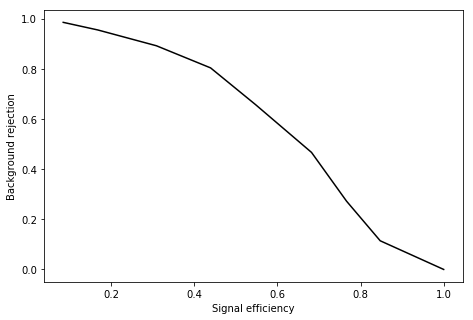

In [15]:
# Plot signal efficiency vs. background rejection.
sg_eff = []; bg_eff = []
tns0 = svsb_tns[0]
tnb0 = svsb_tnb[0]
for bcut,tnb,tns,tot in zip(svsb_bcut,svsb_tnb,svsb_tns,svsb_tot):
    
    bge = tnb/tnb0
    sge = tns/tns0
    
    bg_eff.append(bge)
    sg_eff.append(sge)
    print("[Blob cut {} keV ({} total evts)] signal eff. {:.2f}, background eff. {:.2f}".format(bcut,tot,sge,bge))

sg_eff = np.array(sg_eff)
bg_eff = np.array(bg_eff)

fig = plt.figure()
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.plot(sg_eff,1-bg_eff,'-',c='black')
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")

-----------------

## Radial and z distributions

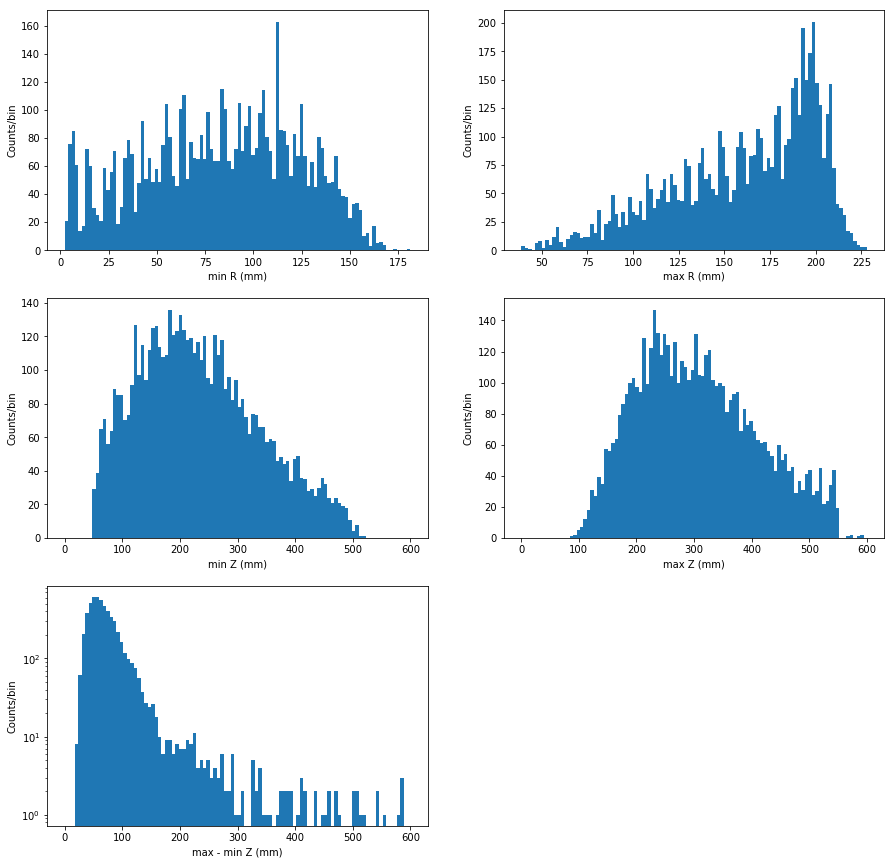

In [16]:
# Distributions in r and z
cuts_rz_Cs = C_basic & (A_Ec*CAL_FACTOR > 650) & (A_Ec*CAL_FACTOR < 680)
cuts_rz_Th = C_basic & (A_Ec*CAL_FACTOR > 1580) & (A_Ec*CAL_FACTOR < 1650)

cuts_rz = cuts_rz_Th

fig = plt.figure(1)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

# Rmin distribution
ax1 = fig.add_subplot(321);
plt.hist(A_rmin[cuts_rz],bins=100)
plt.xlabel('min R (mm)')
plt.ylabel('Counts/bin')

# Rmax distribution
ax2 = fig.add_subplot(322);
plt.hist(A_rmax[cuts_rz],bins=100)
plt.xlabel('max R (mm)')
plt.ylabel('Counts/bin')

# zmin distribution
ax3 = fig.add_subplot(323);
plt.hist(A_zmin[cuts_rz],bins=100,range=[0,600])
plt.xlabel('min Z (mm)')
plt.ylabel('Counts/bin')

# zmax distribution
ax4 = fig.add_subplot(324);
plt.hist(A_zmax[cuts_rz],bins=100,range=[0,600])
plt.xlabel('max Z (mm)')
plt.ylabel('Counts/bin')

# event distribution in z
ax5 = fig.add_subplot(325);
plt.hist(A_zmax[cuts_rz]-A_zmin[cuts_rz],bins=100,range=[0,600])
plt.yscale('log')
plt.xlabel('max - min Z (mm)')
plt.ylabel('Counts/bin')

## x-y, and distributions

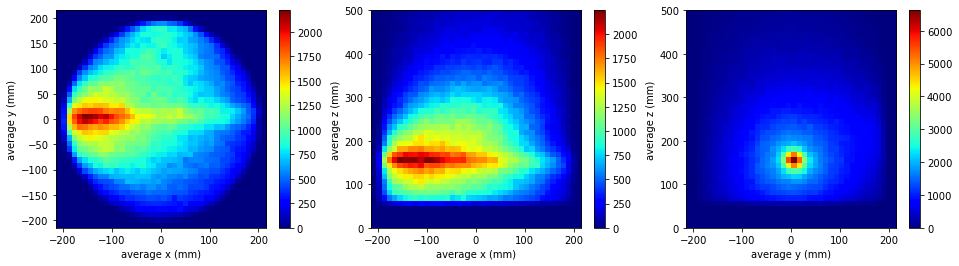

In [17]:
# Distribution in x-y
cuts_xy_Cs = C_basic #& (A_Ec*CAL_FACTOR > 650) & (A_Ec*CAL_FACTOR < 680)
cuts_xy_Th = C_basic #& (A_Ec*CAL_FACTOR > 1580) & (A_Ec*CAL_FACTOR < 1650)

cuts_xy = C_basic
nxybins = 40

fig = plt.figure(1);
fig.set_figheight(4.0);
fig.set_figwidth(16.0);

# x-y distribution
ax1 = fig.add_subplot(131)
plt.hist2d(A_xavg[cuts_xy], A_yavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (-215, 215)), cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")

# x-z distribution
ax2 = fig.add_subplot(132)
plt.hist2d(A_xavg[cuts_xy], A_zavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (0, 500)), cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average z (mm)")

# y-z distribution
ax3 = fig.add_subplot(133)
plt.hist2d(A_yavg[cuts_xy], A_zavg[cuts_xy], (nxybins, nxybins), ((-215, 215), (0, 500)), cmap='jet')
plt.colorbar()
plt.xlabel("average y (mm)")
plt.ylabel("average z (mm)")

plt.savefig("fig/CSTL_xyzdist.pdf", bbox_inches='tight')

## Energy spectrum (double-escape peak)

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


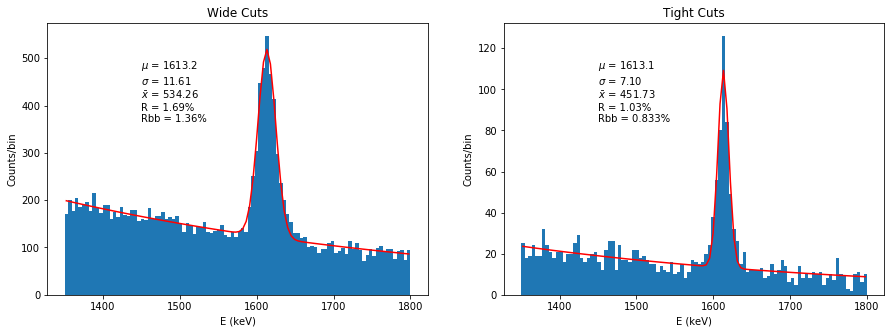

In [23]:
# Energy spectrum, focusing on double-escape peak
cuts_espec_wide  = C_wide
cuts_espec_tight = C_tight

plt_rng = [1350,1800]
nbins = 100
fit_rng_low = 1300
fit_rng_high = 1800
text_x = 1450
fit_gauss_A = 120
fit_gauss_mu = 1610
fit_gauss_sigma = 30
fit_exp_A = 20
fit_exp_mean = 600
fit_exp_x0 = 1200

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

## WIDE cuts
ax1 = fig.add_subplot(121);
y0, x0, _ = plt.hist(A_Ec[cuts_espec_wide]*CAL_FACTOR, nbins, range=plt_rng)

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4*max(y)/6, gaussexpotext(f.values,1592.))
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.title("Wide Cuts")

## TIGHT cuts
ax2 = fig.add_subplot(122);
y0, x0, _ = plt.hist(A_Ec[cuts_espec_tight]*CAL_FACTOR, nbins, range=plt_rng)

# Gaussian + exponential fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4*max(y)/6, gaussexpotext(f.values,1592.))
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.title("Tight Cuts")

plt.savefig("fig/CSTL_espectrum_doubleescape_fit.pdf", bbox_inches='tight')

# Energy spectrum (Cs 662 keV peak)

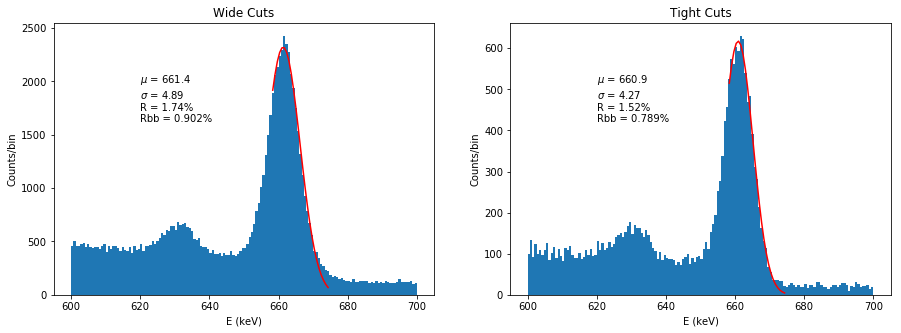

In [19]:
# Energy spectrum, focusing on Cs peak
cuts_espec_wide  = C_wide
cuts_espec_tight = C_tight

plt_rng = [600,700]
nbins = 150
fit_rng_low = 658
fit_rng_high = 675
text_x = 620
fit_gauss_A = 120
fit_gauss_mu = 662
fit_gauss_sigma = 10

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# WIDE cuts
ax1 = fig.add_subplot(121);
y0, x0, _ = plt.hist(A_Ec[cuts_espec_wide]*CAL_FACTOR, nbins, range=plt_rng)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(fitf.gauss, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4*max(y)/6, gausstext(f.values,662.))
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.title("Wide Cuts")

# TIGHT cuts
ax1 = fig.add_subplot(122);
y0, x0, _ = plt.hist(A_Ec[cuts_espec_tight]*CAL_FACTOR, nbins, range=plt_rng)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(fitf.gauss, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 4*max(y)/6, gausstext(f.values,662.))
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.title("Tight Cuts")

plt.savefig("fig/CSTL_espectrum_Cs_fit.pdf", bbox_inches='tight')

## Energy spectrum (2.6 MeV peak)

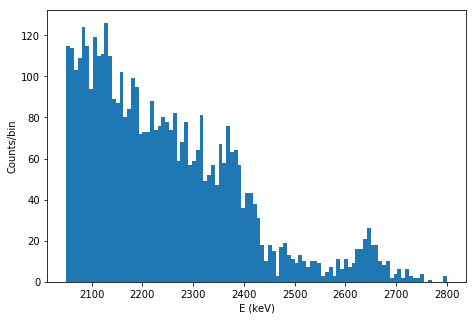

In [20]:
# Energy spectrum, focusing on 2.6 MeV peak
cuts_peak2pt6 = C_basic

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

y, x, _ = plt.hist(A_Ec[cuts_peak2pt6]*CAL_FACTOR, 100, range=[2050,2800])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

plt.savefig("fig/CSTL_espectrum_Tl.pdf", bbox_inches='tight')

## Energy spectrum (two regions)

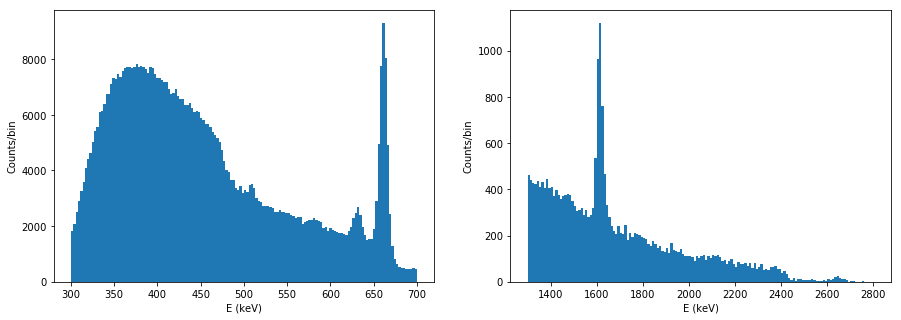

In [21]:
# Energy spectrum, focusing on 2.6 MeV peak
cuts_regionCs = C_wide
cuts_regionTl = C_wide

plt_rng_Cs = [300,700]
nbins_Cs = 150

plt_rng_Tl = [1300,2800]
nbins_Tl = 150

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# Cs region
ax1 = fig.add_subplot(121)
y, x, _ = plt.hist(A_Ec[cuts_regionCs]*CAL_FACTOR, nbins, range=plt_rng_Cs)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

# Tl region
ax2 = fig.add_subplot(122)
y, x, _ = plt.hist(A_Ec[cuts_regionTl]*CAL_FACTOR, nbins, range=plt_rng_Tl)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

plt.savefig("fig/CSTL_espectrum_2regions.pdf", bbox_inches='tight')

## Time evolution of energy

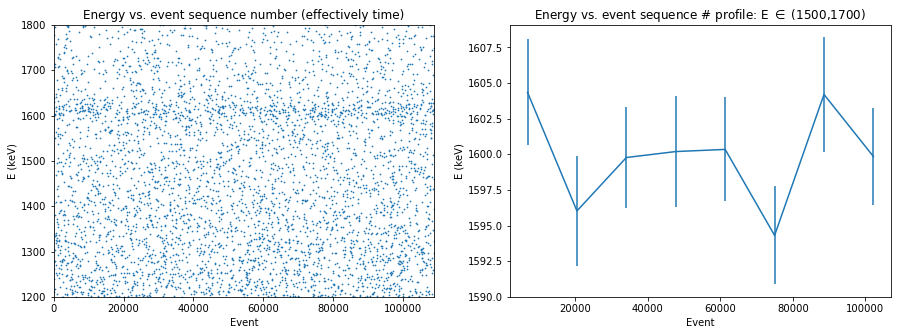

In [22]:
# Energy vs. event (effectively "time")
cuts_time = C_basic

Ehist_min = 1500
Ehist_max = 1700
enseq = np.array(range(len(A_Ec[cuts_time])))
tprof, Eprof, Eerr = fitf.profileX(enseq,A_Ec[cuts_time]*CAL_FACTOR,nbins=8,xrange=(0,109000),yrange=(Ehist_min,Ehist_max))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
ax1.scatter(enseq,A_Ec[cuts_time]*CAL_FACTOR,s=0.5)
plt.title("Energy vs. event sequence number (effectively time)")
plt.ylim([1200,1800])
plt.xlim([0,109000])
plt.xlabel('Event')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122)
ax2.errorbar(tprof,Eprof,yerr=Eerr)
plt.title("Energy vs. event sequence # profile: E $\in$ ({0},{1})".format(Ehist_min,Ehist_max))
plt.xlabel('Event')
plt.ylabel('E (keV)')

## Energy as a function of z

In [ ]:
# Energy vs. Z
cuts_z = C_basic

nbins = 8

# for double-escape peak
zhist_min_D = 50
zhist_max_D = 500
Ehist_min_D = 1575
Ehist_max_D = 1665
plt_rng_Zlow_D = 0
plt_rng_Zhigh_D = 500
plt_rng_Elow_D = 1400
plt_rng_Ehigh_D = 1800

# for Cs peak
zhist_min_Cs = 50
zhist_max_Cs = 500
Ehist_min_Cs = 648
Ehist_max_Cs = 680
plt_rng_Zlow_Cs = 0
plt_rng_Zhigh_Cs = 500
plt_rng_Elow_Cs = 600
plt_rng_Ehigh_Cs = 700

zprof_D, Eprof_D, Eerr_D = fitf.profileX(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,nbins=nbins,xrange=(zhist_min_D,zhist_max_D),yrange=(Ehist_min_D,Ehist_max_D))
zprof_Cs, Eprof_Cs, Eerr_Cs = fitf.profileX(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,nbins=nbins,xrange=(zhist_min_Cs,zhist_max_Cs),yrange=(Ehist_min_Cs,Ehist_max_Cs))

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
ax1.scatter(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,s=0.5)
ax1.axhline(y=Ehist_min_D,xmin=plt_rng_Zlow_D,xmax=plt_rng_Zhigh_D,c="red",linewidth=1.2,linestyle='dashed')
ax1.axhline(y=Ehist_max_D,xmin=plt_rng_Zlow_D,xmax=plt_rng_Zhigh_D,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. average Z")
plt.ylim([plt_rng_Elow_D,plt_rng_Ehigh_D])
plt.xlim([plt_rng_Zlow_D,plt_rng_Zhigh_D])
plt.xlabel('Z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(222);
ax2.errorbar(zprof_D,Eprof_D,yerr=Eerr_D)
plt.title("Energy vs. average Z profile: E $\in$ ({0},{1})".format(Ehist_min_D,Ehist_max_D))
plt.xlabel('Z (mm)')
plt.ylabel('E (keV)')

ax3 = fig.add_subplot(223);
ax3.scatter(A_zavg[cuts_z],A_Ec[cuts_z]*CAL_FACTOR,s=0.5)
ax3.axhline(y=Ehist_min_Cs,xmin=plt_rng_Zlow_Cs,xmax=plt_rng_Zhigh_Cs,c="red",linewidth=1.2,linestyle='dashed')
ax3.axhline(y=Ehist_max_Cs,xmin=plt_rng_Zlow_Cs,xmax=plt_rng_Zhigh_Cs,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. average Z")
plt.ylim([plt_rng_Elow_Cs,plt_rng_Ehigh_Cs])
plt.xlim([plt_rng_Zlow_Cs,plt_rng_Zhigh_Cs])
plt.xlabel('Z (mm)')
plt.ylabel('E (keV)')

ax4 = fig.add_subplot(224);
ax4.errorbar(zprof_Cs,Eprof_Cs,yerr=Eerr_Cs)
plt.title("Energy vs. average Z profile: E $\in$ ({0},{1})".format(Ehist_min_Cs,Ehist_max_Cs))
plt.xlabel('Z (mm)')
plt.ylabel('E (keV)')

## Energy as a function of r

In [ ]:
# Energy vs. Z
cuts_R = C_basic

nbins = 8

# for double-escape peak
Rhist_min_D = 0
Rhist_max_D = 180
Ehist_min_D = 1575
Ehist_max_D = 1665
plt_rng_Rlow_D = 0
plt_rng_Rhigh_D = 200
plt_rng_Elow_D = 1400
plt_rng_Ehigh_D = 1800

# for Cs peak
Rhist_min_Cs = 0
Rhist_max_Cs = 180
Ehist_min_Cs = 650
Ehist_max_Cs = 682
plt_rng_Rlow_Cs = 0
plt_rng_Rhigh_Cs = 200
plt_rng_Elow_Cs = 600
plt_rng_Ehigh_Cs = 700

Rprof_D, Eprof_D, Eerr_D = fitf.profileX(A_ravg[cuts_R],A_Ec[cuts_R]*CAL_FACTOR,nbins=nbins,xrange=(Rhist_min_D,Rhist_max_D),yrange=(Ehist_min_D,Ehist_max_D))
Rprof_Cs, Eprof_Cs, Eerr_Cs = fitf.profileX(A_ravg[cuts_R],A_Ec[cuts_R]*CAL_FACTOR,nbins=nbins,xrange=(Rhist_min_Cs,Rhist_max_Cs),yrange=(Ehist_min_Cs,Ehist_max_Cs))

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
ax1.scatter(A_ravg[cuts_R],A_Ec[cuts_R]*CAL_FACTOR,s=0.5)
ax1.axhline(y=Ehist_min_D,xmin=plt_rng_Rlow_D,xmax=plt_rng_Rhigh_D,c="red",linewidth=1.2,linestyle='dashed')
ax1.axhline(y=Ehist_max_D,xmin=plt_rng_Rlow_D,xmax=plt_rng_Rhigh_D,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. average R")
plt.ylim([plt_rng_Elow_D,plt_rng_Ehigh_D])
plt.xlim([plt_rng_Rlow_D,plt_rng_Rhigh_D])
plt.xlabel('R (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(222);
ax2.errorbar(Rprof_D,Eprof_D,yerr=Eerr_D)
plt.title("Energy vs. average R profile: E $\in$ ({0},{1})".format(Ehist_min_D,Ehist_max_D))
plt.xlabel('R (mm)')
plt.ylabel('E (keV)')

ax3 = fig.add_subplot(223);
ax3.scatter(A_ravg[cuts_R],A_Ec[cuts_R]*CAL_FACTOR,s=0.5)
ax3.axhline(y=Ehist_min_Cs,xmin=plt_rng_Rlow_Cs,xmax=plt_rng_Rhigh_Cs,c="red",linewidth=1.2,linestyle='dashed')
ax3.axhline(y=Ehist_max_Cs,xmin=plt_rng_Rlow_Cs,xmax=plt_rng_Rhigh_Cs,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. average R")
plt.ylim([plt_rng_Elow_Cs,plt_rng_Ehigh_Cs])
plt.xlim([plt_rng_Rlow_Cs,plt_rng_Rhigh_Cs])
plt.xlabel('R (mm)')
plt.ylabel('E (keV)')

ax4 = fig.add_subplot(224);
ax4.errorbar(Rprof_Cs,Eprof_Cs,yerr=Eerr_Cs)
plt.title("Energy vs. average R profile: E $\in$ ({0},{1})".format(Ehist_min_Cs,Ehist_max_Cs))
plt.xlabel('R (mm)')
plt.ylabel('E (keV)')

-----------------------

---------------------